# 因子排序策略实现

https://www.pybroker.com/zh-cn/latest/notebooks/7.%20Creating%20a%20Custom%20Data%20Source.html

In [1]:
import pybroker
from pybroker.ext.data import AKShare
from pybroker import ExecContext, StrategyConfig, Strategy
from pybroker.data import DataSource
import matplotlib.pyplot as plt
from datetime import datetime
import riskfolio as rp
import akshare as ak
import pandas as pd
import numpy as np
import sqlite3
import datetime

import talib
from pybroker.vect import cross

#正常显示画图时出现的中文和负号
from pylab import mpl

mpl.rcParams['font.sans-serif']=['SimHei']
mpl.rcParams['axes.unicode_minus']=False

akshare = AKShare()

pybroker.enable_data_source_cache('akshare')

## 本地数据的策略使用

In [2]:
conn=sqlite3.connect(r'I:\量化金融\stock_2018.db')
stock_daily0=pd.read_sql("select * from stock_daily where 股票代码>'003000.SZ'",con=conn)
stock_daily0["交易日期"]=pd.to_datetime(stock_daily0["交易日期"].astype(str))

In [4]:
#stock_daily0

In [3]:
stock_daily0["交易日期"].min()

Timestamp('2018-01-02 00:00:00')

In [4]:
stock_daily0["交易日期"].max()

Timestamp('2023-02-17 00:00:00')

In [4]:
pyb_data_pe=stock_daily0[["交易日期","股票代码","开盘价","最高价","最低价","收盘价","成交量(手)","市盈率(静态)"]]
pyb_data_pe.columns=["date","symbol","open","high","low","close","volume","pe"]

In [5]:
def trying_strategy_pe(ctx: ExecContext):
    high = ctx.high[-11:-1].max()
    low = ctx.low[-11:-1].min()
    #print(ctx.pe[-1])

    if not ctx.long_pos() and ctx.close[-1] > high and ctx.pe[-1] > 150:
        ctx.buy_shares = ctx.calc_target_shares(0.5)
    
    if ctx.long_pos() and ctx.close[-1] < low:
        ctx.sell_all_shares()

In [6]:
pybroker.register_columns('pe')
strategy = Strategy(pyb_data_pe, '2018-02-22', '2023-02-10')
strategy.add_execution(trying_strategy_pe, pyb_data_pe.symbol.unique()[100:120])
result = strategy.backtest(warmup=15)

Backtesting: 2018-02-22 00:00:00 to 2023-02-10 00:00:00

Test split: 2018-02-22 00:00:00 to 2023-02-10 00:00:00


  0% (0 of 1207) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--
  2% (31 of 1207) |                      | Elapsed Time: 0:00:00 ETA:   0:00:01
  9% (111 of 1207) |#                    | Elapsed Time: 0:00:00 ETA:   0:00:00
 19% (231 of 1207) |####                 | Elapsed Time: 0:00:00 ETA:   0:00:00
 25% (311 of 1207) |#####                | Elapsed Time: 0:00:00 ETA:   0:00:00
 29% (361 of 1207) |######               | Elapsed Time: 0:00:00 ETA:   0:00:00
 34% (421 of 1207) |#######              | Elapsed Time: 0:00:00 ETA:   0:00:00
 42% (511 of 1207) |########             | Elapsed Time: 0:00:00 ETA:   0:00:00
 51% (621 of 1207) |##########           | Elapsed Time: 0:00:00 ETA:   0:00:00
 58% (711 of 1207) |############         | Elapsed Time: 0:00:00 ETA:   0:00:00
 68% (831 of 1207) |##############       | Elapsed Time: 0:00:00 ETA:   0:00:00
 73% (891 of 1207) |###############      | Elapsed Time: 0:00:00 ETA:   0:00:00
 77% (941 of 1207) |################    


Finished backtest: 0:00:05


In [7]:
result.metrics_df.head()

,name,value
0,trade_count,42.00
1,initial_market_value,100000.00
2,end_market_value,128756.01
3,total_pnl,19031.60
4,unrealized_pnl,9724.41


<Axes: xlabel='date'>

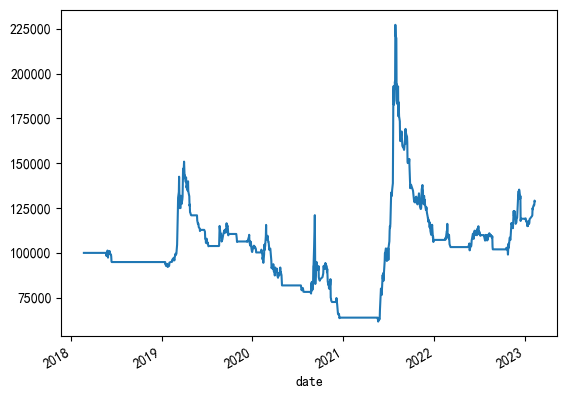

In [8]:
result.portfolio.equity.plot()

## 用沪深300作为对比基准

* ak.index_zh_a_hist 获取沪深300的指数历史数据的方法并作图

In [9]:
index_zh_a_hist_df = ak.index_zh_a_hist(symbol="000300", period="daily", start_date="20180222", end_date="20230210")
index_zh_a_hist_df["日期"]=pd.to_datetime(index_zh_a_hist_df["日期"])
index_zh_a_hist_df.set_index("日期",inplace=True)
print(index_zh_a_hist_df)

  0%|          | 0/16 [00:00<?, ?it/s]

                 开盘       收盘       最高       最低        成交量           成交额    振幅  \
日期                                                                              
2018-02-22  4020.97  4052.73  4058.79  4009.92  105811571  1.383344e+11  1.23   
2018-02-23  4061.75  4071.09  4085.20  4035.23   99458747  1.281958e+11  1.23   
2018-02-26  4093.40  4118.42  4128.74  4048.98  137881001  1.790131e+11  1.96   
2018-02-27  4120.87  4058.98  4120.87  4051.81  125934469  1.696849e+11  1.68   
2018-02-28  4016.79  4023.64  4051.71  3991.71  109343593  1.524939e+11  1.48   
...             ...      ...      ...      ...        ...           ...   ...   
2023-02-06  4103.83  4086.88  4105.94  4065.22  110192717  2.263451e+11  0.98   
2023-02-07  4098.31  4094.23  4107.34  4077.96   91360072  1.835374e+11  0.72   
2023-02-08  4099.86  4076.14  4111.47  4072.65   84786099  1.705918e+11  0.95   
2023-02-09  4067.56  4130.86  4130.86  4064.75  102289961  2.117226e+11  1.62   
2023-02-10  4124.10  4106.31

In [177]:
index_zh_a_hist_df["收盘"].index

DatetimeIndex(['2018-02-22', '2018-02-23', '2018-02-26', '2018-02-27',
               '2018-02-28', '2018-03-01', '2018-03-02', '2018-03-05',
               '2018-03-06', '2018-03-07',
               ...
               '2023-01-30', '2023-01-31', '2023-02-01', '2023-02-02',
               '2023-02-03', '2023-02-06', '2023-02-07', '2023-02-08',
               '2023-02-09', '2023-02-10'],
              dtype='datetime64[ns]', name='日期', length=1207, freq=None)

In [178]:
result.portfolio.equity.index

DatetimeIndex(['2018-02-22', '2018-02-23', '2018-02-26', '2018-02-27',
               '2018-02-28', '2018-03-01', '2018-03-02', '2018-03-05',
               '2018-03-06', '2018-03-07',
               ...
               '2023-01-30', '2023-01-31', '2023-02-01', '2023-02-02',
               '2023-02-03', '2023-02-06', '2023-02-07', '2023-02-08',
               '2023-02-09', '2023-02-10'],
              dtype='datetime64[ns]', name='date', length=1207, freq=None)

<Axes: xlabel='date'>

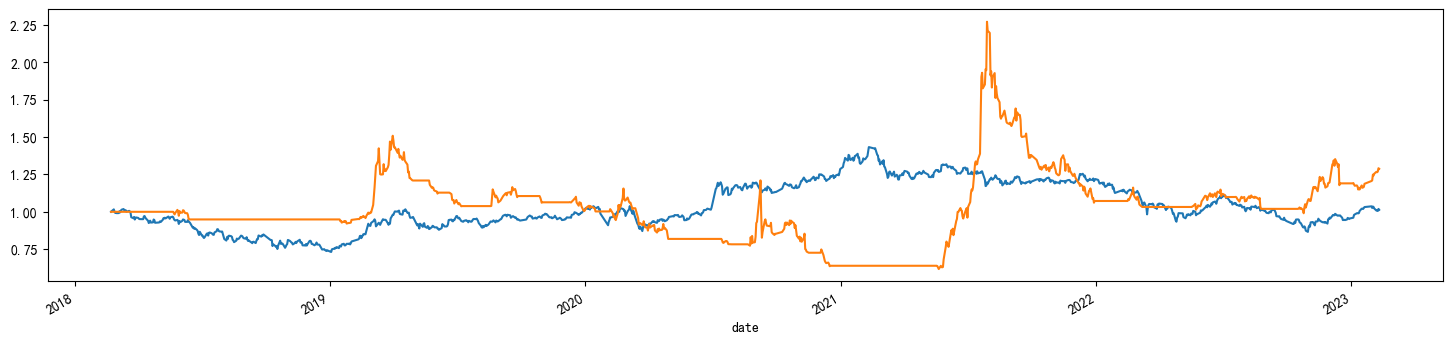

In [10]:
index_close=index_zh_a_hist_df["收盘"]
index_time_scale=index_close/index_close.iloc[0]
index_time_scale.plot(figsize=(18,4))
cash_value=result.portfolio.equity/100000
cash_value.plot()

## 基于ctx.score的因子排序策略实现

In [54]:
stock_daily0.columns

Index(['index', '交易日期', '股票代码', '股票简称', '开盘价', '最高价', '最低价', '收盘价', '成交量(手)',
       '成交额(千元)', '换手率(%)', '量比', '市盈率(静态)', '市盈率(TTM)', '市盈率(动态)', '市净率',
       '市销率', '市销率(TTM)', '股息率(%)', '股息率(TTM)(%)', '总股本(万股)', '流通股本(万股)',
       '总市值(万元)', '流通市值(万元)'],
      dtype='object')

In [41]:
pyb_data_pe=stock_daily0[["交易日期","股票代码","开盘价","最高价","最低价","收盘价","成交量(手)","换手率(%)"]]
pyb_data_pe.columns=["date","symbol","open","high","low","close","volume","pe"]

In [42]:
pyb_data_pe

,date,symbol,open,high,low,close,volume,pe
0,2020-10-13,003001.SZ,36.1900,43.4300,36.1900,43.4300,1755.12,0.7225
1,2020-10-14,003001.SZ,47.7700,47.7700,44.0100,47.7700,109022.37,44.8766
2,2020-10-15,003001.SZ,46.4400,46.8000,43.0400,43.0900,81268.36,33.4523
3,2020-10-16,003001.SZ,41.0200,43.8900,40.1100,41.9400,57613.41,23.7152
4,2020-10-19,003001.SZ,41.1300,41.8000,39.2500,39.4500,47553.71,19.5744
...,...,...,...,...,...,...,...,...
1132744,2023-02-13,430047.BJ,6161.7118,6395.8655,6161.7118,6317.8143,9090.62,0.4889
1132745,2023-02-14,430047.BJ,6330.8228,6365.5122,6287.4610,6365.5122,4324.41,0.2326
1132746,2023-02-15,430047.BJ,6339.4952,6408.8740,6339.4952,6348.1675,2639.02,0.1419
1132747,2023-02-16,430047.BJ,6326.4866,6391.5293,6183.3927,6222.4183,4853.73,0.2611


In [43]:
def buy_highest_volume(ctx):
    # If there are no long positions across all tickers being traded:
    if not tuple(ctx.long_positions()):
        ctx.buy_shares = ctx.calc_target_shares(0.1)
        ctx.hold_bars = 10
        ctx.score = -ctx.pe[-1]

In [44]:
pybroker.register_columns('pe')
config = StrategyConfig(max_long_positions=10)
strategy = Strategy(pyb_data_pe, '2018-01-01', '2023-02-10', config)
strategy.add_execution(buy_highest_volume, pyb_data_pe.symbol.unique())
result = strategy.backtest()

Backtesting: 2018-01-01 00:00:00 to 2023-02-10 00:00:00

Test split: 2018-01-02 00:00:00 to 2023-02-10 00:00:00


  0% (0 of 1239) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--
  0% (1 of 1239) |                       | Elapsed Time: 0:00:01 ETA:   0:24:03
  0% (11 of 1239) |                      | Elapsed Time: 0:00:02 ETA:   0:03:48
  1% (21 of 1239) |                      | Elapsed Time: 0:00:02 ETA:   0:02:08
  2% (31 of 1239) |                      | Elapsed Time: 0:00:02 ETA:   0:01:33
  3% (41 of 1239) |                      | Elapsed Time: 0:00:02 ETA:   0:01:11
  4% (51 of 1239) |                      | Elapsed Time: 0:00:02 ETA:   0:01:00
  4% (61 of 1239) |#                     | Elapsed Time: 0:00:02 ETA:   0:00:53
  5% (71 of 1239) |#                     | Elapsed Time: 0:00:02 ETA:   0:00:46
  6% (81 of 1239) |#                     | Elapsed Time: 0:00:02 ETA:   0:00:42
  7% (91 of 1239) |#                     | Elapsed Time: 0:00:03 ETA:   0:00:39
  8% (101 of 1239) |#                    | Elapsed Time: 0:00:03 ETA:   0:00:36
  8% (111 of 1239) |#                   


Finished backtest: 0:00:24


In [45]:
result.metrics_df.head()

,name,value
0,trade_count,1019.00
1,initial_market_value,100000.00
2,end_market_value,8169187.38
3,total_pnl,7992617.52
4,unrealized_pnl,76569.86


<Axes: xlabel='date'>

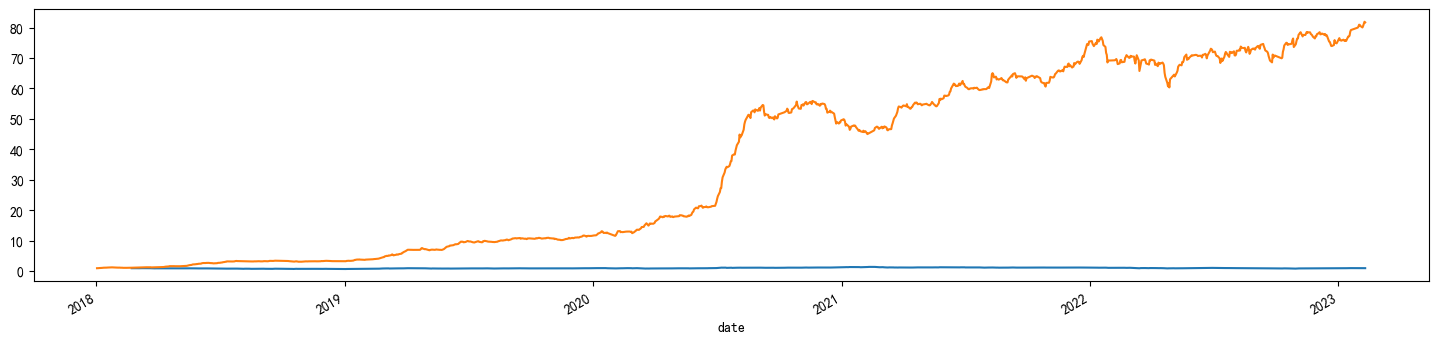

In [11]:
index_close=index_zh_a_hist_df["收盘"]
index_time_scale=index_close/index_close.iloc[0]
index_time_scale.plot(figsize=(18,4))
cash_value=result.portfolio.equity/100000
cash_value.plot()

In [33]:
#result.trades

In [40]:
result.trades

,type,symbol,entry_date,exit_date,entry,exit,shares,pnl,return_pct,agg_pnl,bars,pnl_per_bar,stop,mae,mfe
id,,,,,,,,,,,,,,,
1,long,300063.SZ,2020-04-02,2020-04-17,35.30,42.72,584,4333.28,21.02,4333.28,10,433.33,bar,-2.36,7.54
2,long,300062.SZ,2020-04-02,2020-04-17,26.74,26.45,743,-215.47,-1.08,4117.81,10,-21.55,bar,-2.00,1.32
3,long,300073.SZ,2020-04-02,2020-04-17,95.43,102.32,208,1433.12,7.22,5550.93,10,143.31,bar,-2.40,6.98
4,long,300079.SZ,2020-04-02,2020-04-17,62.78,62.22,324,-181.44,-0.89,5369.49,10,-18.14,bar,-2.19,5.20
5,long,300072.SZ,2020-04-02,2020-04-17,93.39,95.01,206,333.72,1.73,5703.21,10,33.37,bar,-2.13,6.39
6,long,300063.SZ,2020-04-20,2020-05-07,41.11,39.66,522,-756.90,-3.53,4946.31,10,-75.69,bar,-2.12,6.68
7,long,300077.SZ,2020-04-20,2020-05-07,36.02,37.64,595,963.90,4.50,5910.21,10,96.39,bar,-1.26,3.47
8,long,300071.SZ,2020-04-20,2020-05-07,25.21,25.43,815,179.30,0.87,6089.51,10,17.93,bar,-1.17,1.39
9,long,300070.SZ,2020-04-20,2020-05-07,182.75,181.84,116,-105.56,-0.50,5983.95,10,-10.56,bar,-14.22,3.64


### 输出策略中的因子排名

In [38]:
def print_rank(ctxs: dict[str, ExecContext]) -> bool:
    dt = tuple(ctxs.values())[0].dt
    print(dt)
    symbols = []
    scores = []
    for ctx in ctxs.values():
        symbols.append(ctx.symbol)
        scores.append(ctx.score)
    
    v_rank = pd.DataFrame({"symbol": symbols, "score": scores}).sort_values(by="score", ascending=False)
    print(v_rank.head(5))

    return False

In [39]:
config = StrategyConfig(max_long_positions=5)
strategy = Strategy(pyb_data_pe, '2020-04-01', '2020-05-10', config)
strategy.add_execution(buy_highest_volume, pyb_data_pe.symbol.unique()[100:120])
strategy.set_after_exec(print_rank)
result = strategy.backtest()

Backtesting: 2020-04-01 00:00:00 to 2020-05-10 00:00:00

Test split: 2020-04-01 00:00:00 to 2020-05-08 00:00:00


  0% (0 of 24) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
  4% (1 of 24) |#                        | Elapsed Time: 0:00:00 ETA:   0:00:01


2020-04-01 00:00:00
       symbol      score
2   300063.SZ  447895.51
1   300062.SZ  312732.10
12  300073.SZ  237493.33
18  300079.SZ  196063.63
11  300072.SZ  171642.58
2020-04-02 00:00:00
      symbol score
0  300061.SZ  None
1  300062.SZ  None
2  300063.SZ  None
3  300064.SZ  None
4  300065.SZ  None
2020-04-03 00:00:00
      symbol score
0  300061.SZ  None
1  300062.SZ  None
2  300063.SZ  None
3  300064.SZ  None
4  300065.SZ  None
2020-04-07 00:00:00
      symbol score
0  300061.SZ  None
1  300062.SZ  None
2  300063.SZ  None
3  300064.SZ  None
4  300065.SZ  None
2020-04-08 00:00:00
      symbol score
0  300061.SZ  None
1  300062.SZ  None
2  300063.SZ  None
3  300064.SZ  None
4  300065.SZ  None
2020-04-09 00:00:00
      symbol score
0  300061.SZ  None
1  300062.SZ  None
2  300063.SZ  None
3  300064.SZ  None
4  300065.SZ  None
2020-04-10 00:00:00
      symbol score
0  300061.SZ  None
1  300062.SZ  None
2  300063.SZ  None
3  300064.SZ  None
4  300065.SZ  None
2020-04-13 00:00:00
      

 45% (11 of 24) |###########             | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (24 of 24) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


2020-04-17 00:00:00
       symbol      score
2   300063.SZ  650549.86
16  300077.SZ  366084.42
10  300071.SZ  317601.69
9   300070.SZ  261548.95
13  300074.SZ  203680.73
2020-04-20 00:00:00
      symbol score
0  300061.SZ  None
1  300062.SZ  None
2  300063.SZ  None
3  300064.SZ  None
4  300065.SZ  None
2020-04-21 00:00:00
      symbol score
0  300061.SZ  None
1  300062.SZ  None
2  300063.SZ  None
3  300064.SZ  None
4  300065.SZ  None
2020-04-22 00:00:00
      symbol score
0  300061.SZ  None
1  300062.SZ  None
2  300063.SZ  None
3  300064.SZ  None
4  300065.SZ  None
2020-04-23 00:00:00
      symbol score
0  300061.SZ  None
1  300062.SZ  None
2  300063.SZ  None
3  300064.SZ  None
4  300065.SZ  None
2020-04-24 00:00:00
      symbol score
0  300061.SZ  None
1  300062.SZ  None
2  300063.SZ  None
3  300064.SZ  None
4  300065.SZ  None
2020-04-27 00:00:00
      symbol score
0  300061.SZ  None
1  300062.SZ  None
2  300063.SZ  None
3  300064.SZ  None
4  300065.SZ  None
2020-04-28 00:00:00
      

In [11]:
#result.trades

## 市盈率与换手率的因子排名策略实现

In [28]:
stock_daily0.columns

Index(['index', '交易日期', '股票代码', '股票简称', '开盘价', '最高价', '最低价', '收盘价', '成交量(手)',
       '成交额(千元)', '换手率(%)', '量比', '市盈率(静态)', '市盈率(TTM)', '市盈率(动态)', '市净率',
       '市销率', '市销率(TTM)', '股息率(%)', '股息率(TTM)(%)', '总股本(万股)', '流通股本(万股)',
       '总市值(万元)', '流通市值(万元)'],
      dtype='object')

In [54]:
pyb_data_pe.sort_values(by="pe").head(5)

,date,symbol,open,high,low,close,volume,pe
280036,2020-08-18,300216.SZ,7.1717,7.1717,7.1717,7.1717,2.0,0.0001
280040,2020-08-24,300216.SZ,4.7098,4.7098,4.7098,4.7098,3.0,0.0001
280029,2020-08-07,300216.SZ,14.8786,14.8786,14.8786,14.8786,2.0,0.0001
280038,2020-08-20,300216.SZ,5.8337,5.8337,5.8337,5.8337,5.0,0.0002
280039,2020-08-21,300216.SZ,5.2450,5.2450,5.2450,5.2450,19.0,0.0007


In [56]:
pyb_data_pe.pe.describe()

count    1.132744e+06
mean     4.284365e+00
std      5.840322e+00
min      1.000000e-04
25%      1.286300e+00
50%      2.404300e+00
75%      4.829600e+00
max      9.611500e+01
Name: pe, dtype: float64

In [61]:
def buy_highest_volume(ctx):
    # If there are no long positions across all tickers being traded:
    if not tuple(ctx.long_positions()):
        ctx.buy_limit_price=ctx.close[-1]*1.095
        ctx.buy_shares = ctx.calc_target_shares(0.1)
        ctx.hold_bars = 10
        ctx.score = -ctx.pe[-1]

In [47]:
pyb_data_pe=stock_daily0[["交易日期","股票代码","开盘价","最高价","最低价","收盘价","成交量(手)","换手率(%)"]]
pyb_data_pe.columns=["date","symbol","open","high","low","close","volume","pe"]

In [62]:
pybroker.register_columns('pe')
config = StrategyConfig(max_long_positions=10)
strategy = Strategy(pyb_data_pe, '2018-01-01', '2023-02-10', config)
strategy.add_execution(buy_highest_volume, pyb_data_pe.symbol.unique())
result = strategy.backtest()

Backtesting: 2018-01-01 00:00:00 to 2023-02-10 00:00:00

Test split: 2018-01-02 00:00:00 to 2023-02-10 00:00:00


  0% (0 of 1239) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--
  0% (1 of 1239) |                       | Elapsed Time: 0:00:01 ETA:   0:27:52
  0% (11 of 1239) |                      | Elapsed Time: 0:00:02 ETA:   0:04:25
  1% (21 of 1239) |                      | Elapsed Time: 0:00:02 ETA:   0:02:29
  2% (31 of 1239) |                      | Elapsed Time: 0:00:02 ETA:   0:01:47
  3% (41 of 1239) |                      | Elapsed Time: 0:00:02 ETA:   0:01:22
  4% (51 of 1239) |                      | Elapsed Time: 0:00:03 ETA:   0:01:10
  4% (61 of 1239) |#                     | Elapsed Time: 0:00:03 ETA:   0:01:01
  5% (71 of 1239) |#                     | Elapsed Time: 0:00:03 ETA:   0:00:55
  6% (81 of 1239) |#                     | Elapsed Time: 0:00:03 ETA:   0:00:50
  7% (91 of 1239) |#                     | Elapsed Time: 0:00:03 ETA:   0:00:46
  8% (101 of 1239) |#                    | Elapsed Time: 0:00:03 ETA:   0:00:42
  8% (111 of 1239) |#                   


Finished backtest: 0:00:28


In [66]:
result.orders.head(12)

,type,symbol,date,shares,limit_price,fill_price,fees
id,,,,,,,
1,buy,300174.SZ,2018-01-03,91,119.56,107.98,0.0
2,buy,300042.SZ,2018-01-03,150,72.52,65.85,0.0
3,buy,300448.SZ,2018-01-03,182,60.10,55.60,0.0
4,buy,300138.SZ,2018-01-03,223,48.92,44.65,0.0
5,buy,300178.SZ,2018-01-03,165,66.02,60.79,0.0
6,buy,300001.SZ,2018-01-03,105,103.89,95.19,0.0
7,buy,300257.SZ,2018-01-03,110,98.81,89.89,0.0
8,buy,300114.SZ,2018-01-03,165,65.99,61.52,0.0
9,buy,300094.SZ,2018-01-03,593,18.44,16.93,0.0


In [63]:
result.metrics_df.head()

,name,value
0,trade_count,1055.00
1,initial_market_value,100000.00
2,end_market_value,148042.77
3,total_pnl,44380.79
4,unrealized_pnl,3661.98


<Axes: xlabel='date'>

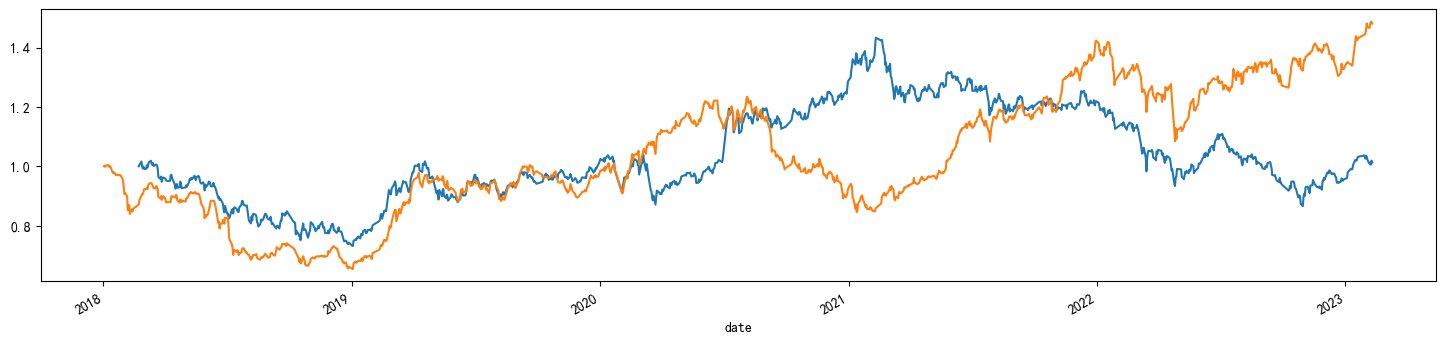

In [64]:
index_close=index_zh_a_hist_df["收盘"]
index_time_scale=index_close/index_close.iloc[0]
index_time_scale.plot(figsize=(18,4))
cash_value=result.portfolio.equity/100000
cash_value.plot()

## 限价与涨停——换手率因子问题解决

* 换手率极小的意义
* buy_limit_price

In [124]:
stock_daily0.columns

Index(['index', '交易日期', '股票代码', '股票简称', '开盘价', '最高价', '最低价', '收盘价', '成交量(手)',
       '成交额(千元)', '换手率(%)', '量比', '市盈率(静态)', '市盈率(TTM)', '市盈率(动态)', '市净率',
       '市销率', '市销率(TTM)', '股息率(%)', '股息率(TTM)(%)', '总股本(万股)', '流通股本(万股)',
       '总市值(万元)', '流通市值(万元)'],
      dtype='object')

In [12]:
pyb_data_huan=stock_daily0[["交易日期","股票代码","开盘价","最高价","最低价","收盘价","成交量(手)","换手率(%)"]]
pyb_data_huan.columns=["date","symbol","open","high","low","close","volume","huanshou"]

In [13]:
pyb_data_huan.huanshou.describe()

count    1.132744e+06
mean     4.284365e+00
std      5.840322e+00
min      1.000000e-04
25%      1.286300e+00
50%      2.404300e+00
75%      4.829600e+00
max      9.611500e+01
Name: huanshou, dtype: float64

In [17]:
def buy_highest_huan(ctx):
    # If there are no long positions across all tickers being traded:
    if not tuple(ctx.long_positions()) and ctx.huanshou[-1] > 1.5:
        ctx.buy_shares = ctx.calc_target_shares(0.2)
        ctx.hold_bars = 25
        ctx.score = -ctx.huanshou[-1]

In [18]:
pybroker.register_columns('huanshou')
config = StrategyConfig(max_long_positions=5)
strategy = Strategy(pyb_data_huan, '2018-02-22', '2023-02-10', config)
strategy.add_execution(buy_highest_huan, pyb_data_huan.symbol.unique())
result = strategy.backtest()

Backtesting: 2018-02-22 00:00:00 to 2023-02-10 00:00:00

Test split: 2018-02-22 00:00:00 to 2023-02-10 00:00:00


  0% (0 of 1207) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--
  0% (1 of 1207) |                       | Elapsed Time: 0:00:00 ETA:   0:12:44
  0% (11 of 1207) |                      | Elapsed Time: 0:00:01 ETA:   0:01:49
  1% (21 of 1207) |                      | Elapsed Time: 0:00:01 ETA:   0:00:59
  2% (31 of 1207) |                      | Elapsed Time: 0:00:01 ETA:   0:01:10
  4% (51 of 1207) |                      | Elapsed Time: 0:00:01 ETA:   0:00:44
  5% (61 of 1207) |#                     | Elapsed Time: 0:00:02 ETA:   0:00:41
  5% (71 of 1207) |#                     | Elapsed Time: 0:00:02 ETA:   0:00:36
  6% (81 of 1207) |#                     | Elapsed Time: 0:00:02 ETA:   0:00:33
  8% (101 of 1207) |#                    | Elapsed Time: 0:00:02 ETA:   0:00:27
  9% (111 of 1207) |#                    | Elapsed Time: 0:00:02 ETA:   0:00:26
 10% (131 of 1207) |##                   | Elapsed Time: 0:00:02 ETA:   0:00:23
 11% (141 of 1207) |##                  


Finished backtest: 0:00:16


In [20]:
result.metrics_df.head()

,name,value
0,trade_count,230.00
1,initial_market_value,100000.00
2,end_market_value,285895.29
3,total_pnl,162355.04
4,unrealized_pnl,23540.25


In [129]:
2850607/100000

28.50607

<Axes: xlabel='date'>

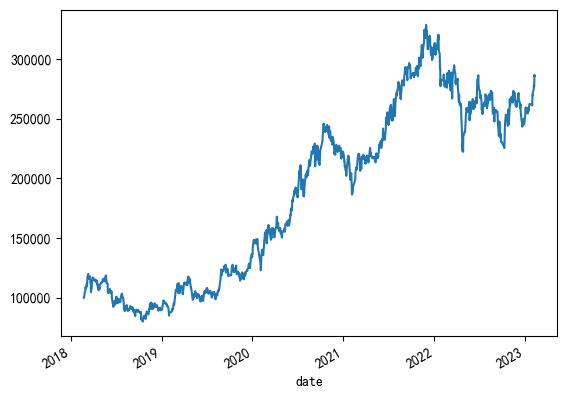

In [202]:
result.portfolio.equity.plot()

In [27]:
stock_daily0.sort_values(by="换手率(%)")[["交易日期","股票代码","开盘价","收盘价","换手率(%)"]].head(3)

,交易日期,股票代码,开盘价,收盘价,换手率(%)
280036,2020-08-18,300216.SZ,7.1717,7.1717,0.0001
280040,2020-08-24,300216.SZ,4.7098,4.7098,0.0001
280029,2020-08-07,300216.SZ,14.8786,14.8786,0.0001


In [29]:
#stock_daily0

In [40]:
def buy_highest_huan(ctx):
    # If there are no long positions across all tickers being traded:
    if not tuple(ctx.long_positions()):
        ctx.buy_limit_price = ctx.close[-1] * 1.095
        ctx.buy_shares = ctx.calc_target_shares(0.2)
        ctx.hold_bars = 25
        ctx.score = -ctx.huanshou[-1]

In [ ]:
def print_rank(ctxs: dict[str, ExecContext]) -> bool:
    dt = tuple(ctxs.values())[0].dt
    print(dt)
    symbols = []
    scores = []
    for ctx in ctxs.values():
        symbols.append(ctx.symbol)
        scores.append(ctx.score)
    
    v_rank = pd.DataFrame({"symbol": symbols, "score": scores}).sort_values(by="score", ascending=False)
    print(v_rank.head(7))

    return False

In [55]:
pybroker.register_columns('huanshou')
config = StrategyConfig(max_long_positions=5)
strategy = Strategy(pyb_data_huan, '2018-02-22', '2018-02-24', config)
strategy.add_execution(buy_highest_huan, pyb_data_huan.symbol.unique())
strategy.set_after_exec(print_rank)
result = strategy.backtest()

Backtesting: 2018-02-22 00:00:00 to 2018-02-24 00:00:00

Test split: 2018-02-22 00:00:00 to 2018-02-23 00:00:00


  0% (0 of 2) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--


2018-02-22 00:00:00
        symbol   score
152  300174.SZ -0.0392
96   300110.SZ -0.0931
301  300342.SZ -0.1054
94   300108.SZ -0.1247
336  300381.SZ -0.1263
264  300301.SZ -0.1266
214  300243.SZ -0.1336


 50% (1 of 2) |#############             | Elapsed Time: 0:00:01 ETA:   0:00:01
100% (2 of 2) |##########################| Elapsed Time: 0:00:01 ETA:  00:00:00
100% (2 of 2) |##########################| Elapsed Time: 0:00:01 Time:  0:00:01


2018-02-23 00:00:00
      symbol score
0  300001.SZ  None
1  300002.SZ  None
2  300003.SZ  None
3  300005.SZ  None
4  300006.SZ  None
5  300007.SZ  None
6  300008.SZ  None

Finished backtest: 0:00:02


In [57]:
result.orders.head(10)

,type,symbol,date,shares,limit_price,fill_price,fees
id,,,,,,,
1,buy,300174.SZ,2018-02-23,184,118.65,107.01,0.0
2,buy,300110.SZ,2018-02-23,460,47.60,39.14,0.0
3,buy,300342.SZ,2018-02-23,362,60.47,55.52,0.0
4,buy,300108.SZ,2018-02-23,397,55.14,50.63,0.0
5,buy,300381.SZ,2018-02-23,310,70.63,64.47,0.0


In [58]:
result.metrics_df.head()

,name,value
0,trade_count,0.00
1,initial_market_value,100000.00
2,end_market_value,99715.86
3,total_pnl,0.00
4,unrealized_pnl,-284.14


<Axes: xlabel='date'>

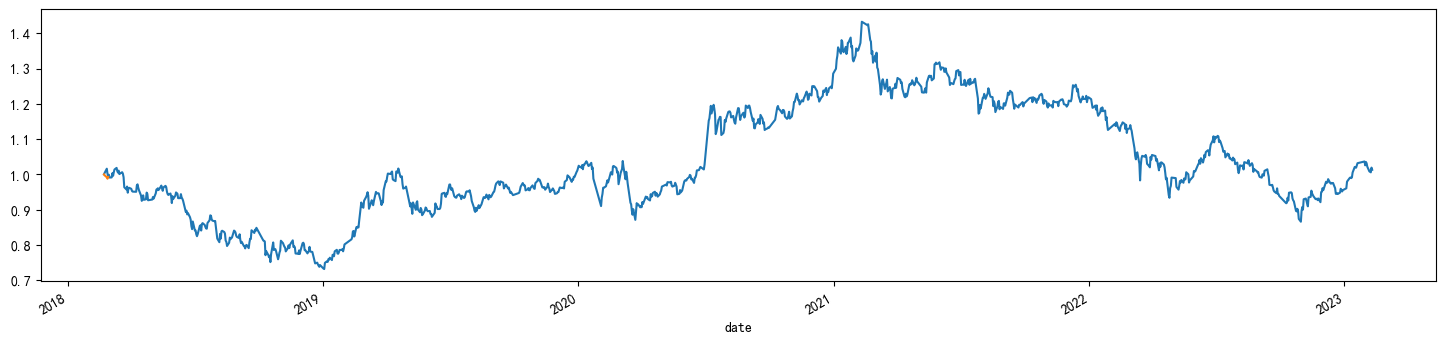

In [52]:
index_time_scale=index_zh_a_hist_df["收盘"]/index_zh_a_hist_df["收盘"].iloc[0]
index_time_scale.plot(figsize=(18,4))
(result.portfolio.equity/100000).plot()

## 多因子策略

1 选择多个因子， 先给每个因子单独排序， 序号加权求和

* pandas 分组回顾

* rank的用法

In [70]:
for i in stock_daily0.groupby("交易日期"):
    print(i[1].sort_values(by="成交量(手)"))
    break

        index       交易日期       股票代码  股票简称       开盘价       最高价       最低价  \
844755      3 2018-01-02  300684.SZ  中石科技   15.3300   15.3300   15.3300   
902773      1 2018-01-02  300735.SZ  光弘科技   15.8300   15.8300   15.8300   
774772    195 2018-01-02  300626.SZ  华瑞股份   28.8000   28.8600   28.1000   
710444    263 2018-01-02  300572.SZ  安车检测   64.1507   64.7680   62.9970   
560223    653 2018-01-02  300448.SZ  浩云科技   54.3084   55.5358   54.3084   
...       ...        ...        ...   ...       ...       ...       ...   
449484   1156 2018-01-02  300355.SZ  蒙草生态  123.0629  124.9245  120.5154   
54093    1793 2018-01-02  300027.SZ  华谊兄弟  133.6618  136.0701  132.0060   
92211    1830 2018-01-02  300059.SZ  东方财富  348.4208  351.6345  344.4037   
126306   1407 2018-01-02  300088.SZ  长信科技  127.4941  129.7708  123.2660   
41864    1935 2018-01-02  300017.SZ  网宿科技  246.7998  254.4832  242.6089   

             收盘价     成交量(手)     成交额(千元)  ...  市盈率(动态)     市净率      市销率  \
844755   15.3300      41.

In [122]:
#group_keys的作用
df = pd.DataFrame({
    'A': ['foo', 'bar', 'foo', 'bar', 'foo', 'bar', 'foo', 'foo'],
    'B': ['one', 'one', 'two', 'three', 'two', 'two', 'one', 'three'],
    'C': [1, 5, 5, 2, 5, 5, 6, 7],
    'D': [2.0, 5., 8., 1., 2., 9., 4., 6.]
})

# 自定义函数，用于计算每个分组的平均C列和D列的和
def custom_func(x):
    return x-len(x)

print(df) 
# 使用groupby应用自定义函数
grouped = df.groupby('A')["C"].apply(custom_func)
print(grouped)
grouped = df.groupby('A', group_keys=False)["C"].apply(custom_func)
print(grouped)

     A      B  C    D
0  foo    one  1  2.0
1  bar    one  5  5.0
2  foo    two  5  8.0
3  bar  three  2  1.0
4  foo    two  5  2.0
5  bar    two  5  9.0
6  foo    one  6  4.0
7  foo  three  7  6.0
A     
bar  1    2
     3   -1
     5    2
foo  0   -4
     2    0
     4    0
     6    1
     7    2
Name: C, dtype: int64
0   -4
1    2
2    0
3   -1
4    0
5    2
6    1
7    2
Name: C, dtype: int64


In [73]:
stock_daily0.groupby("交易日期")["市盈率(静态)"].rank()

0          115.0
1          152.0
2          119.0
3          108.0
4           90.0
           ...  
1132744      NaN
1132745      NaN
1132746      NaN
1132747      NaN
1132748      NaN
Name: 市盈率(静态), Length: 1132749, dtype: float64

In [60]:
stock_daily0.columns

Index(['index', '交易日期', '股票代码', '股票简称', '开盘价', '最高价', '最低价', '收盘价', '成交量(手)',
       '成交额(千元)', '换手率(%)', '量比', '市盈率(静态)', '市盈率(TTM)', '市盈率(动态)', '市净率',
       '市销率', '市销率(TTM)', '股息率(%)', '股息率(TTM)(%)', '总股本(万股)', '流通股本(万股)',
       '总市值(万元)', '流通市值(万元)'],
      dtype='object')

In [25]:
stock_daily0.groupby("交易日期")["市盈率(静态)"].rank(ascending=False)

0          646.0
1          610.0
2          644.0
3          657.0
4          676.0
           ...  
1132744      NaN
1132745      NaN
1132746      NaN
1132747      NaN
1132748      NaN
Name: 市盈率(静态), Length: 1132749, dtype: float64

In [74]:
stock_daily0["pe_rank"]=stock_daily0.groupby("交易日期")["市盈率(静态)"].rank(ascending=False)
stock_daily0["hs_rank"]=stock_daily0.groupby("交易日期")["换手率(%)"].rank()
stock_daily0["sz_rank"]=stock_daily0.groupby("交易日期")["总市值(万元)"].rank()

In [76]:
#stock_daily0.head(10)

In [65]:
pyb_data_huan.symbol.unique()

array(['003001.SZ', '003002.SZ', '003003.SZ', ..., '301398.SZ',
       '301419.SZ', '430047.BJ'], dtype=object)

In [73]:
stock_daily0[stock_daily0["交易日期"]=="2023-02-10"].sort_values(by="市盈率(静态)")[["交易日期","股票代码","开盘价","收盘价","市盈率(静态)","pe_rank"]].head(10)

,交易日期,股票代码,开盘价,收盘价,市盈率(静态),pe_rank
837457,2023-02-10,300677.SZ,151.1040,152.4829,2.3559,1103.0
211215,2023-02-10,300158.SZ,40.7969,40.5614,2.7047,1102.0
1059739,2023-02-10,300981.SZ,40.5587,41.5137,2.7286,1101.0
792099,2023-02-10,300639.SZ,83.9986,83.7654,9.2632,1100.0
901533,2023-02-10,300732.SZ,45.1845,45.4174,9.8451,1099.0
358765,2023-02-10,300280.SZ,18.8467,19.2859,9.8604,1098.0
333048,2023-02-10,300259.SZ,55.5570,55.5570,10.4133,1097.0
1004826,2023-02-10,300867.SZ,18.7662,18.8877,10.7535,1096.0
256633,2023-02-10,300196.SZ,54.5076,54.2606,10.9817,1095.0
725245,2023-02-10,300584.SZ,44.4498,43.5868,11.6609,1094.0


In [77]:
stock_daily0["muti_factor_rank"]=stock_daily0["pe_rank"]*1+stock_daily0["hs_rank"]*0.3+stock_daily0["sz_rank"]*0.9

In [76]:
#stock_daily0["muti_factor_rank"]

In [78]:
pyb_data_huan=stock_daily0[["交易日期","股票代码","开盘价","最高价","最低价","收盘价","成交量(手)","muti_factor_rank"]]
pyb_data_huan.columns=["date","symbol","open","high","low","close","volume","huanshou",]

In [83]:
def buy_highest_huan(ctx):
    # If there are no long positions across all tickers being traded:
    if not tuple(ctx.long_positions()):
        ctx.buy_limit_price = ctx.close[-1] * 1.095
        ctx.buy_shares = ctx.calc_target_shares(0.1)
        ctx.hold_bars = 25
        ctx.score = -ctx.huanshou[-1]

In [84]:
pybroker.register_columns('huanshou')
config = StrategyConfig(max_long_positions=10)
strategy = Strategy(pyb_data_huan, '2018-02-22', '2023-02-24', config)
strategy.add_execution(buy_highest_huan, pyb_data_huan.symbol.unique())
result = strategy.backtest()

Backtesting: 2018-02-22 00:00:00 to 2023-02-24 00:00:00

Test split: 2018-02-22 00:00:00 to 2023-02-17 00:00:00


  0% (0 of 1212) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--
  0% (1 of 1212) |                       | Elapsed Time: 0:00:01 ETA:   0:31:04
  0% (11 of 1212) |                      | Elapsed Time: 0:00:02 ETA:   0:04:39
  1% (21 of 1212) |                      | Elapsed Time: 0:00:02 ETA:   0:02:30
  2% (31 of 1212) |                      | Elapsed Time: 0:00:02 ETA:   0:01:50
  4% (51 of 1212) |                      | Elapsed Time: 0:00:03 ETA:   0:01:09
  5% (61 of 1212) |#                     | Elapsed Time: 0:00:03 ETA:   0:01:01
  5% (71 of 1212) |#                     | Elapsed Time: 0:00:03 ETA:   0:00:54
  6% (81 of 1212) |#                     | Elapsed Time: 0:00:03 ETA:   0:00:49
  8% (101 of 1212) |#                    | Elapsed Time: 0:00:03 ETA:   0:00:41
  9% (111 of 1212) |#                    | Elapsed Time: 0:00:03 ETA:   0:00:39
  9% (121 of 1212) |##                   | Elapsed Time: 0:00:04 ETA:   0:00:36
 10% (131 of 1212) |##                  


Finished backtest: 0:00:23


In [85]:
result.metrics_df.head()

,name,value
0,trade_count,460.00
1,initial_market_value,100000.00
2,end_market_value,329087.05
3,total_pnl,224226.82
4,unrealized_pnl,4860.23


<Axes: xlabel='date'>

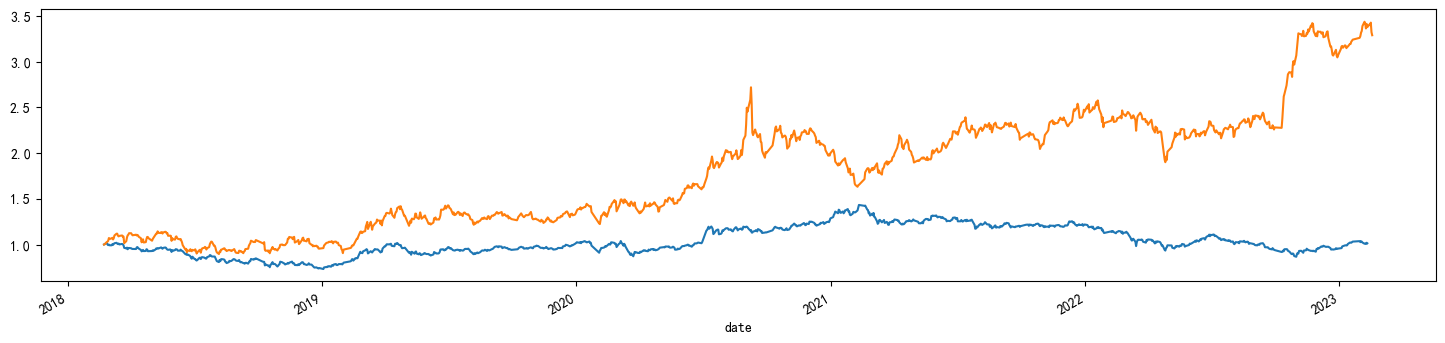

In [86]:
index_close=index_zh_a_hist_df["收盘"]
index_time_scale=index_close/index_close.iloc[0]
index_time_scale.plot(figsize=(18,4))
cash_value=result.portfolio.equity/100000
cash_value.plot()

## 因子轮动交易

* set_before_exec

In [87]:
stock_daily0.columns

Index(['index', '交易日期', '股票代码', '股票简称', '开盘价', '最高价', '最低价', '收盘价', '成交量(手)',
       '成交额(千元)', '换手率(%)', '量比', '市盈率(静态)', '市盈率(TTM)', '市盈率(动态)', '市净率',
       '市销率', '市销率(TTM)', '股息率(%)', '股息率(TTM)(%)', '总股本(万股)', '流通股本(万股)',
       '总市值(万元)', '流通市值(万元)', 'pe_rank', 'hs_rank', 'sz_rank',
       'muti_factor_rank'],
      dtype='object')

In [92]:
pyb_data_ld=stock_daily0[["交易日期","股票代码","开盘价","最高价","最低价","收盘价","成交量(手)","市盈率(静态)"]]
pyb_data_ld.columns=["date","symbol","open","high","low","close","volume","lundong",]

In [109]:
def rand_ld(ctxs: dict[str, ExecContext]) -> bool:
    dt = tuple(ctxs.values())[0].dt
    symbols = []
    lundong = []
    for ctx in ctxs.values():
        symbols.append(ctx.symbol)
        lundong.append(ctx.lundong[-1])
    
    v_rank = pd.DataFrame({"symbol": symbols, "lundong": lundong}).sort_values(by="lundong", ascending=False)
    pybroker.param('symbols',v_rank.head(5).symbol.values)

In [112]:
def lundong_fuc(ctx):
    if ctx.long_pos():
        if ctx.symbol not in pybroker.param('symbols'):
            ctx.sell_all_shares()
    else:
        ctx.buy_limit_price = ctx.close[-1] * 1.095
        ctx.buy_shares = ctx.calc_target_shares(0.1)
        ctx.score = ctx.lundong[-1]

In [119]:
pybroker.register_columns('lundong')
config = StrategyConfig(max_long_positions=10)
strategy = Strategy(pyb_data_ld, '2018-02-22', '2019-04-01', config)
strategy.add_execution(lundong_fuc, pyb_data_ld.symbol.unique())
strategy.set_before_exec(rand_ld)
result = strategy.backtest()

Backtesting: 2018-02-22 00:00:00 to 2019-04-01 00:00:00

Test split: 2018-02-22 00:00:00 to 2019-04-01 00:00:00


  0% (0 of 270) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--
  0% (1 of 270) |                        | Elapsed Time: 0:00:01 ETA:   0:07:37
  4% (11 of 270) |                       | Elapsed Time: 0:00:03 ETA:   0:01:30
  7% (21 of 270) |#                      | Elapsed Time: 0:00:04 ETA:   0:00:56
 11% (31 of 270) |##                     | Elapsed Time: 0:00:05 ETA:   0:00:42
 15% (41 of 270) |###                    | Elapsed Time: 0:00:06 ETA:   0:00:35
 18% (51 of 270) |####                   | Elapsed Time: 0:00:07 ETA:   0:00:31
 22% (61 of 270) |#####                  | Elapsed Time: 0:00:08 ETA:   0:00:27
 26% (71 of 270) |######                 | Elapsed Time: 0:00:09 ETA:   0:00:25
 30% (81 of 270) |######                 | Elapsed Time: 0:00:09 ETA:   0:00:23
 33% (91 of 270) |#######                | Elapsed Time: 0:00:10 ETA:   0:00:21
 37% (101 of 270) |########              | Elapsed Time: 0:00:11 ETA:   0:00:19
 41% (111 of 270) |#########            


Finished backtest: 0:00:27


In [120]:
result.metrics_df.head()

,name,value
0,trade_count,2191.00
1,initial_market_value,100000.00
2,end_market_value,79861.04
3,total_pnl,-20664.46
4,unrealized_pnl,525.50


In [117]:
# result.orders.head(40)

In [198]:
config = StrategyConfig(max_long_positions=7)
pybroker.param('target_size', 1 / config.max_long_positions)

0.14285714285714285

In [204]:
def rand_ld(ctxs: dict[str, ExecContext]):
    #print(tuple(ctxs.values())[0].dt)
    symbols=[]
    ld=[]
    for ctx in ctxs.values():
        symbols.append(ctx.symbol)
        ld.append(ctx.lundong[-1])
    
    v_rank=pd.DataFrame({"symbol":symbols,"ld":ld}).sort_values(by="ld",ascending=False)
    pybroker.param('symbols', v_rank.head(config.max_long_positions).symbol.values)

In [205]:
def rotate(ctx: ExecContext):
    if ctx.long_pos():
        if ctx.symbol not in pybroker.param('symbols'):
            ctx.sell_all_shares()
    else:
        ctx.buy_limit_price = ctx.close[-1] * 1.095
        target_size = pybroker.param('target_size')
        ctx.buy_shares = ctx.calc_target_shares(target_size)
        ctx.score = ctx.lundong[-1]

In [206]:
pybroker.register_columns('lundong')
strategy = Strategy(pyb_data_ld, '2018-02-22', '2019-03-24', config)
strategy.add_execution(rotate, pyb_data_ld.symbol.unique())
strategy.set_before_exec(rand_ld)
result = strategy.backtest()

Backtesting: 2018-02-22 00:00:00 to 2019-03-24 00:00:00

Test split: 2018-02-22 00:00:00 to 2019-03-22 00:00:00


  0% (0 of 264) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--
  0% (1 of 264) |                        | Elapsed Time: 0:00:01 ETA:   0:04:45
  4% (11 of 264) |                       | Elapsed Time: 0:00:02 ETA:   0:00:58
  7% (21 of 264) |#                      | Elapsed Time: 0:00:03 ETA:   0:00:37
 11% (31 of 264) |##                     | Elapsed Time: 0:00:03 ETA:   0:00:28
 15% (41 of 264) |###                    | Elapsed Time: 0:00:04 ETA:   0:00:25
 19% (51 of 264) |####                   | Elapsed Time: 0:00:05 ETA:   0:00:22
 23% (61 of 264) |#####                  | Elapsed Time: 0:00:06 ETA:   0:00:20
 26% (71 of 264) |######                 | Elapsed Time: 0:00:06 ETA:   0:00:18
 30% (81 of 264) |#######                | Elapsed Time: 0:00:07 ETA:   0:00:16
 34% (91 of 264) |#######                | Elapsed Time: 0:00:08 ETA:   0:00:15
 38% (101 of 264) |########              | Elapsed Time: 0:00:08 ETA:   0:00:14
 42% (111 of 264) |#########            


Finished backtest: 0:00:21


In [207]:
result.metrics_df.head()

,name,value
0,trade_count,760.00
1,initial_market_value,100000.00
2,end_market_value,9257.34
3,total_pnl,-90663.46
4,unrealized_pnl,-79.20


<Axes: xlabel='date'>

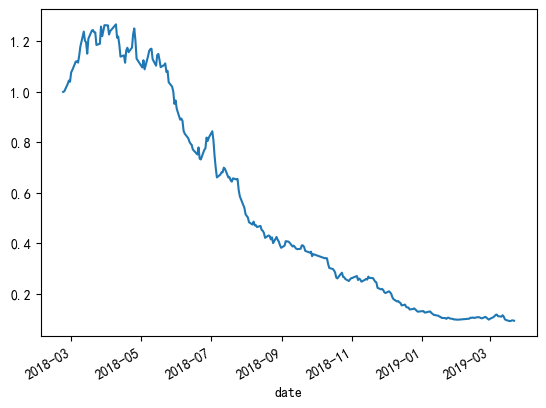

In [208]:
cash_value=result.portfolio.equity/100000
cash_value.plot()

## talib因子构建

`talib.ROC` 是技术分析库 `TA-Lib` 中的一个函数，用于计算价格的变动率（Rate of Change，ROC）指标。变动率指标是一种技术分析工具，它通过比较当前价格与过去某一时期的价格，来衡量价格的变化速度和幅度，帮助投资者判断市场的买卖信号和趋势强度。

### 计算公式
ROC 指标的计算公式如下：
$$ROC = \frac{Close - Close_{n}}{Close_{n}} \times 100$$
其中：
- `Close` 是当前的收盘价。
- `Close_{n}` 是 `n` 个周期前的收盘价。
- `n` 是计算 ROC 指标所使用的周期数。

### 应用场景
- **判断市场买卖信号**：当 ROC 指标从负数变为正数时，可能是买入信号；当 ROC 指标从正数变为负数时，可能是卖出信号。
- **衡量市场趋势强度**：ROC 指标的绝对值越大，说明价格的变化速

In [194]:
def factor(x):
    return talib.ROC(x, timeperiod=10)

In [195]:
stock_daily0["roc"]=stock_daily0.groupby("股票代码", group_keys=False)["收盘价"].apply(factor)

In [193]:
(43.09-43.43)/43.43

-0.007828689845728674

In [196]:
stock_daily0[stock_daily0["股票代码"]=="003001.SZ"][["交易日期","收盘价","roc"]].head(30)

,交易日期,收盘价,roc
0,2020-10-13,43.43,NaN
1,2020-10-14,47.77,NaN
2,2020-10-15,43.09,NaN
3,2020-10-16,41.94,NaN
4,2020-10-19,39.45,NaN
5,2020-10-20,39.12,NaN
6,2020-10-21,40.12,NaN
7,2020-10-22,38.68,NaN
8,2020-10-23,37.40,NaN
9,2020-10-26,37.62,NaN
